In [1]:
# Feature engineering and model selection
from sklearn.pipeline import Pipeline

# Models and metrics
from sklearn.calibration import calibration_curve

# Classification metrics
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, auc

# Suppress all warnings
import warnings
warnings.filterwarnings('ignore')

# Plotting

# Analytical helper functions to declutter the notebook
from analysis.ml.custom_transformers import *
from analysis.ml.data import calculate_label_uniquness
from analysis.stats import *
from analysis.ml.data import get_ml_features

# Other imports
import pandas as pd
import numpy as np
import joblib

In [2]:
# Specify window sizes for rolling min-max and z-score scaling
window_sizes_scaling = [7, 30, 90, 180, 365]

# Specify window sizes for returns-based features
window_sizes_returns = [1, 7, 30, 90, 180, 365]

# Specify lookback window for correlation features
lookback_windows_correlation = [7, 30, 90, 180, 365]

# Specify maximum holding times for triple barrier labeling
max_holding_times_triple_barrier_label = [7]

# Specify lookback window for horizontal barriers for triple barrier labeling
std_lookback_windows = [7]

# Pipeline for feature engineering and modeling
feature_engineering_pipeline = Pipeline([

    ('ta_features', TAFeatures(windows = window_sizes_scaling)),

    ('time_features', TimeFeatures()),

    # ('returns_features', ReturnsFeatures(
    #     window_sizes = window_sizes_returns,
    #     lookback_windows = lookback_windows_correlation,
    # )),

    ('order_book_features', OrderBookFeatures()),

    ('correlation_features', CorrelationFeatures(
        window_sizes = window_sizes_returns, 
        lookback_windows = lookback_windows_correlation,
        period = '1d'
    )),

    ('rolling_z_score', RollingZScoreScaler(window_sizes = window_sizes_scaling)),

    ('fill_na', FillNaTransformer()),

    # ('lag_features', LagFeatures([1, 2, 3, 4, 5, 6, 7])),

    ('triple_barrier_labels', TripleBarrierLabelFeatures(
        max_holding_times = max_holding_times_triple_barrier_label, 
        std_lookback_windows = std_lookback_windows
    )),

])

In [2]:
X = get_ml_features()
X = calculate_label_uniquness(X)

print('X shape:', X.shape)
X.head()

X shape: (191550, 6063)


,symbol_id,time_period_end,asset_id_base,asset_id_quote,exchange_id,open,close,high,low,volume,...,cross_correlation_returns_365_365_BTC_rz_7,cross_correlation_returns_365_365_BTC_rz_30,cross_correlation_returns_365_365_BTC_rz_90,cross_correlation_returns_365_365_BTC_rz_180,cross_correlation_returns_365_365_BTC_rz_365,triple_barrier_label_h7,trade_returns_h7,start_date_triple_barrier_label_h7,end_date_triple_barrier_label_h7,avg_uniqueness
0,1INCH_USDT_BINANCE,2022-01-02,1INCH,USDT,BINANCE,2.391,2.531,2.537,2.391,6304300.0,...,0.707107,0.707107,0.707107,0.707107,0.707107,0.0,-0.159621,2022-01-02,2022-01-09,0.339732
1,1INCH_USDT_BINANCE,2022-01-03,1INCH,USDT,BINANCE,2.532,2.556,2.582,2.466,7334248.0,...,0.707107,0.707107,0.707107,0.707107,0.707107,0.0,-0.159624,2022-01-03,2022-01-10,0.230357
2,1INCH_USDT_BINANCE,2022-01-04,1INCH,USDT,BINANCE,2.556,2.560,2.660,2.497,11827732.0,...,0.707107,0.707107,0.707107,0.707107,0.707107,0.0,-0.187891,2022-01-04,2022-01-11,0.183482
3,1INCH_USDT_BINANCE,2022-01-05,1INCH,USDT,BINANCE,2.560,2.481,2.600,2.459,9650025.0,...,0.707107,0.707107,0.707107,0.707107,0.707107,0.0,-0.133414,2022-01-05,2022-01-12,0.162649
4,1INCH_USDT_BINANCE,2022-01-06,1INCH,USDT,BINANCE,2.479,2.322,2.582,2.200,13524584.0,...,0.707107,0.707107,0.707107,0.707107,0.707107,0.0,-0.033592,2022-01-06,2022-01-13,0.152232


In [3]:
# Columns we need to drop before training the model
triple_barrier_label_cols = [
    col for col in X if 'triple_barrier_label_h' in col
]

trade_returns_cols = [
    col for col in X if 'trade_returns' in col
]

non_numeric_cols = [
    'asset_id_base', 'asset_id_quote', 'exchange_id', 'Unnamed: 0', 'symbol_id'
]

forward_returns_cols = [
    'open', 'high', 'low', 'close', 'start_date_triple_barrier_label_h24', 
    'end_date_triple_barrier_label_h24', 'avg_uniqueness', 'time_period_end'
]

cols_to_drop = (
    triple_barrier_label_cols + 
    trade_returns_cols + 
    non_numeric_cols +
    forward_returns_cols
)

In [4]:
# Ensure train_date_cutoff is a datetime object to prevent data leakage
train_date_cutoff = X['time_period_end'].quantile(0.7)

# Split the dataset into training and testing set
X_train = X[X['time_period_end'] <= train_date_cutoff]
X_test = X[
    (X['time_period_end'] > train_date_cutoff) &
    (X['time_period_end'] <= '2023-12-31')
]

train_min_date = X_train['time_period_end'].min()
train_max_date = X_train['time_period_end'].max()

test_min_date = X_test['time_period_end'].min()
test_max_date = X_test['time_period_end'].max()

print('Training set date range:', train_min_date, train_max_date)
print('Testing set date range:', test_min_date, test_max_date)

# Ensure no data leakage
data_leakage_indicator = (
    # Ensure that the training set doesn't overlap with the testing set
    (X_train['time_period_end'].max() >= X_test['time_period_end'].min())
)
assert not data_leakage_indicator, 'Data leakage detected!'

y_train = ((X_train['triple_barrier_label_h7'] == 1) | ((X_train['triple_barrier_label_h7'] == 0) & (X_train['trade_returns_h7'] > 0))).astype(int)
y_test = ((X_test['triple_barrier_label_h7'] == 1) | ((X_test['triple_barrier_label_h7'] == 0) & (X_test['trade_returns_h7'] > 0))).astype(int)

# Filters for the training and testing set
# train_filter = (
#     X_train['returns_1_rz_24'].abs() >= 1
# )

# test_filter = (
#     X_test['returns_1_rz_24'] >= 1
# )

# Apply the filters (Optional)
# X_train = X_train[train_filter]
# X_test = X_test[test_filter]

# y_train = y_train[train_filter]
# y_test = y_test[test_filter]

# Make these columns categorical for XGBoost
X_train[['symbol_id', 'time_period_end']] = X_train[['symbol_id', 'time_period_end']].astype('category')
X_test[['symbol_id', 'time_period_end']] = X_test[['symbol_id', 'time_period_end']].astype('category')

Training set date range: 2017-08-18 00:00:00 2023-08-11 00:00:00
Testing set date range: 2023-08-12 00:00:00 2023-12-31 00:00:00


In [5]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print()
print('Y train distribution of sample weights:')

X_train['y_train'] = y_train
train_weights = X_train[['y_train', 'avg_uniqueness']].groupby('y_train').sum()
train_weights /= train_weights.sum()
print(train_weights)
X_train.drop('y_train', axis = 1, inplace = True)

print()
print('Y test distribution of sample weights:')

X_test['y_test'] = y_test
test_weights = X_test[['y_test', 'avg_uniqueness']].groupby('y_test').sum()
test_weights /= test_weights.sum()
print(test_weights)
X_test.drop('y_test', axis = 1, inplace = True)

X_train shape: (134136, 6063)
X_test shape: (24238, 6063)

Y train distribution of sample weights:
         avg_uniqueness
y_train                
0              0.542849
1              0.457151

Y test distribution of sample weights:
        avg_uniqueness
y_test                
0             0.493769
1             0.506231


In [6]:
# Load pretrained model
path = '/Users/louisspencer/Desktop/Trading-Bot/data/pretrained_models/classification/xgboost_model_and_metrics_2023_july_to_sept.pkl'
model, model_performance = joblib.load(path)

In [7]:
model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              class_weight='balanced', colsample_bylevel=0.8559090842950567,
              colsample_bynode=0.663065021208513,
              colsample_bytree=0.5426695597771782, device=None,
              early_stopping_rounds=30, enable_categorical=True,
              eval_metric=None, feature_types=None, gamma=1.9703766262891769,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.27791884365191294,
              max_bin=500, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=14, max_leaves=None,
              min_child_weight=2.110134526557927, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=5, num_parallel_tree=None, ...)

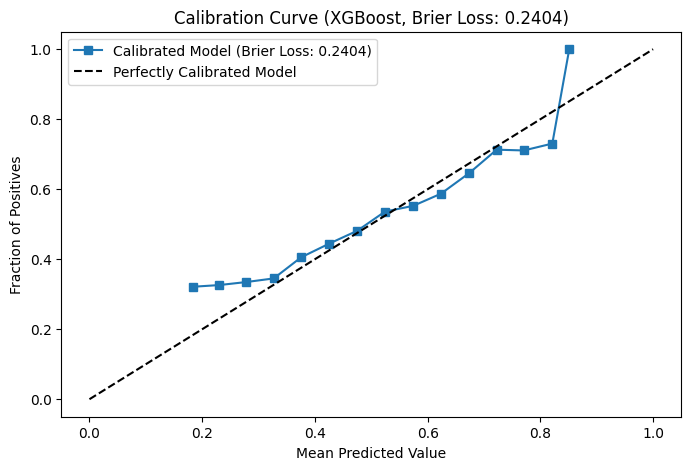

In [21]:
# Calibration curve for calibrated model on test set
fig, ax = plt.subplots(1, 1, figsize = (8, 5))

fraction_of_positives, mean_predicted_value = calibration_curve(y_test, model.predict_proba(X_test.drop(columns = cols_to_drop, errors = 'ignore'))[:, 1], n_bins = 20)

ax.plot(mean_predicted_value, fraction_of_positives, 's-', label = f'Calibrated Model (Brier Loss: {brier_calibrated:.4f})')
ax.plot([0, 1], [0, 1], '--', color = 'black', label = 'Perfectly Calibrated Model')
ax.legend()
ax.set_title(f'Calibration Curve (XGBoost, Brier Loss: {brier_calibrated:.4f})')
ax.set_xlabel('Mean Predicted Value')
ax.set_ylabel('Fraction of Positives');

In [31]:
# Performance Metrics
pred_prob_test = model.predict_proba(X_test.drop(columns = cols_to_drop + ['time_period_end'], errors = 'ignore'))[:, 1]
y_pred_test = model.predict(X_test.drop(columns = cols_to_drop + ['time_period_end'], errors = 'ignore'))

print('XGBoost Test Performance:')
print()
print(classification_report(y_test, y_pred_test, sample_weight = X_test['avg_uniqueness'].fillna(1)))
print()
print('Baseline Model Performance (Random):')
print()
print(classification_report(y_test, np.random.randint(0, 2, len(y_test)), sample_weight = X_test['avg_uniqueness'].fillna(1)))

XGBoost Test Performance:

              precision    recall  f1-score   support

           0       0.58      0.57      0.57 11894.148752834466
           1       0.59      0.60      0.59 12299.30394132653

    accuracy                           0.58 24193.452694160995
   macro avg       0.58      0.58      0.58 24193.452694160995
weighted avg       0.58      0.58      0.58 24193.452694160995


Baseline Model Performance (Random):

              precision    recall  f1-score   support

           0       0.49      0.51      0.50 11894.148752834466
           1       0.51      0.50      0.51 12299.30394132653

    accuracy                           0.50 24193.452694160995
   macro avg       0.50      0.50      0.50 24193.452694160995
weighted avg       0.50      0.50      0.50 24193.452694160995



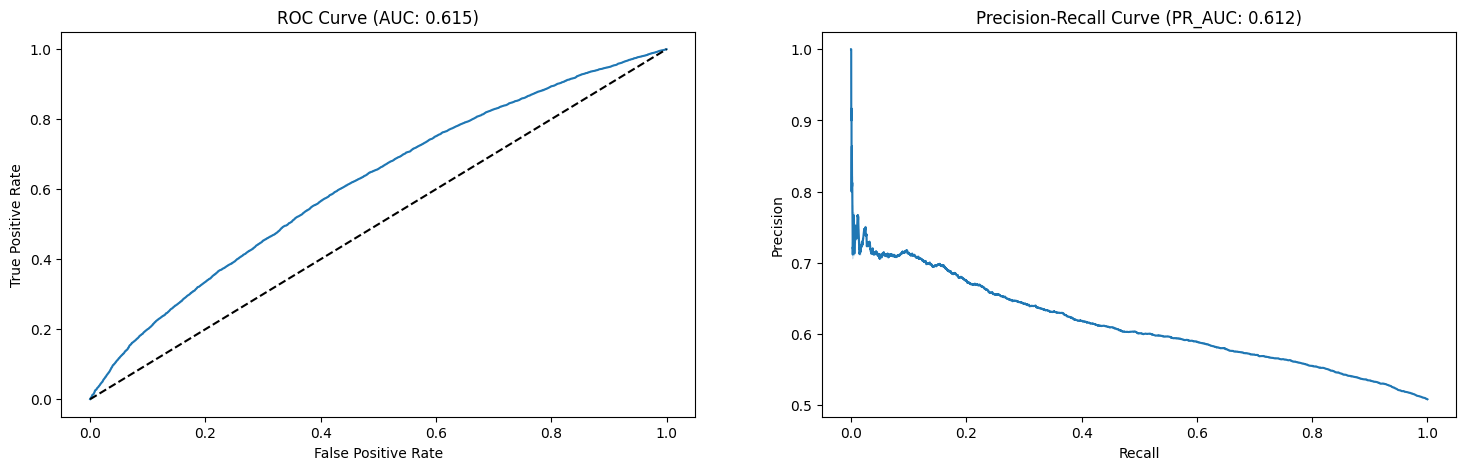

In [13]:
# Plot the ROC curve (2 subplots)
fig, ax = plt.subplots(1, 2, figsize = (18, 5))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, pred_prob_test, sample_weight = X_test['avg_uniqueness'].fillna(1))
roc_auc = auc(fpr, tpr)

sns.lineplot(x = fpr, y = tpr, ax = ax[0])
sns.lineplot(x = [0, 1], y = [0, 1], color = 'black', linestyle = '--', ax = ax[0])
ax[0].set_title(f'ROC Curve (AUC: {roc_auc:.3f})')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, pred_prob_test, sample_weight = X_test['avg_uniqueness'].fillna(1))
pr_auc = auc(recall, precision)

sns.lineplot(x = recall, y = precision, ax = ax[1])
ax[1].set_title(f'Precision-Recall Curve (PR_AUC: {pr_auc:.3f})')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')

plt.show()

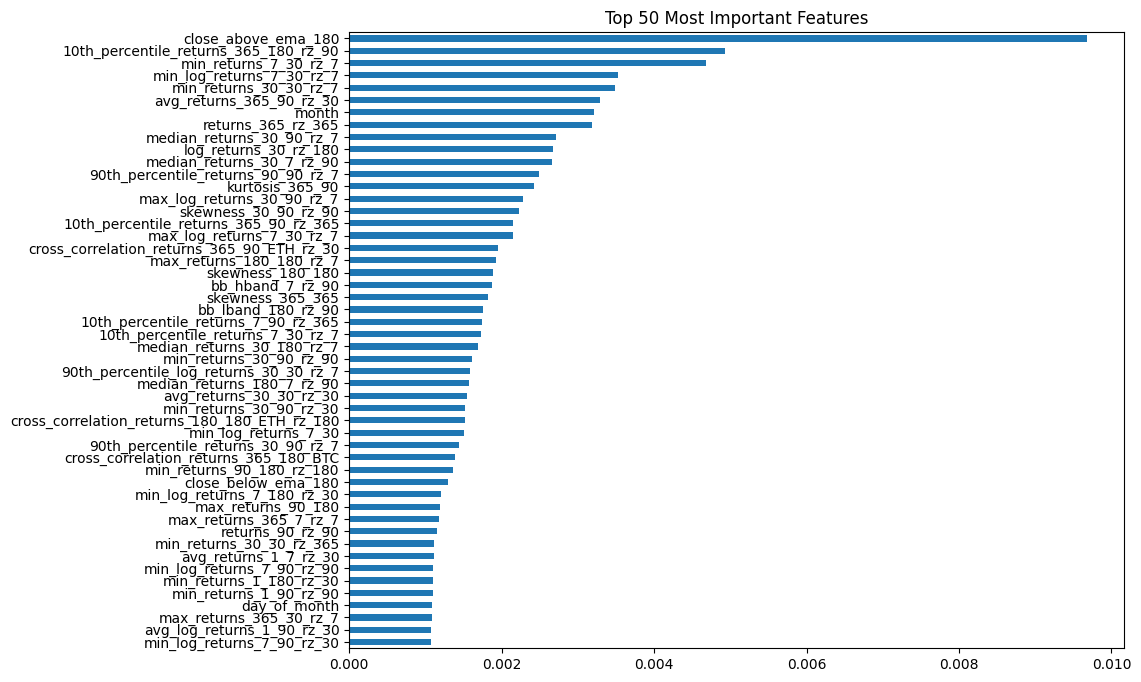

In [14]:
# Plot top N most important features as horizontal bar plot
top_n = 50
feature_importances = pd.Series(model.feature_importances_, index = X_train.drop(columns = cols_to_drop + ['time_period_end'], errors = 'ignore').columns)
feature_importances = feature_importances.sort_values().tail(top_n)

plt.figure(figsize = (10, 8))
feature_importances.plot(kind = 'barh')
plt.title(f'Top {top_n} Most Important Features')
plt.show()

In [34]:
# Calculate the sample statistic on the test set
X_test['y_pred'] = y_pred_test
sample_means = X_test[['y_pred', 'trade_returns_h7']].groupby('y_pred').mean()
sample_statistic = round(sample_means.loc[1, 'trade_returns_h7'] - sample_means.loc[0, 'trade_returns_h7'], 3)

# Calculate the information coefficient of the model's predictions
information_coefficient = round(X_test[['y_pred', 'trade_returns_h7']].corr().iloc[0, 1], 3)
print('Information Coefficient:', information_coefficient)

# Calculate the sample statistic for a random baseline
X_test['y_pred_random'] = np.random.randint(0, 2, len(X_test))
sample_means_random = X_test[['y_pred_random', 'trade_returns_h7']].groupby('y_pred_random').mean()
sample_statistic_random = round(sample_means_random.loc[1, 'trade_returns_h7'] - sample_means_random.loc[0, 'trade_returns_h7'], 3)

print(f'Sample statistic: {sample_statistic}')
print(f'Random baseline statistic: {sample_statistic_random}')
print()
print(sample_means)
print()
print(sample_means_random)

Information Coefficient: 0.095
Sample statistic: 0.015
Random baseline statistic: 0.0

        trade_returns_h7
y_pred                  
0              -0.000427
1               0.014215

               trade_returns_h7
y_pred_random                  
0                      0.007127
1                      0.007178


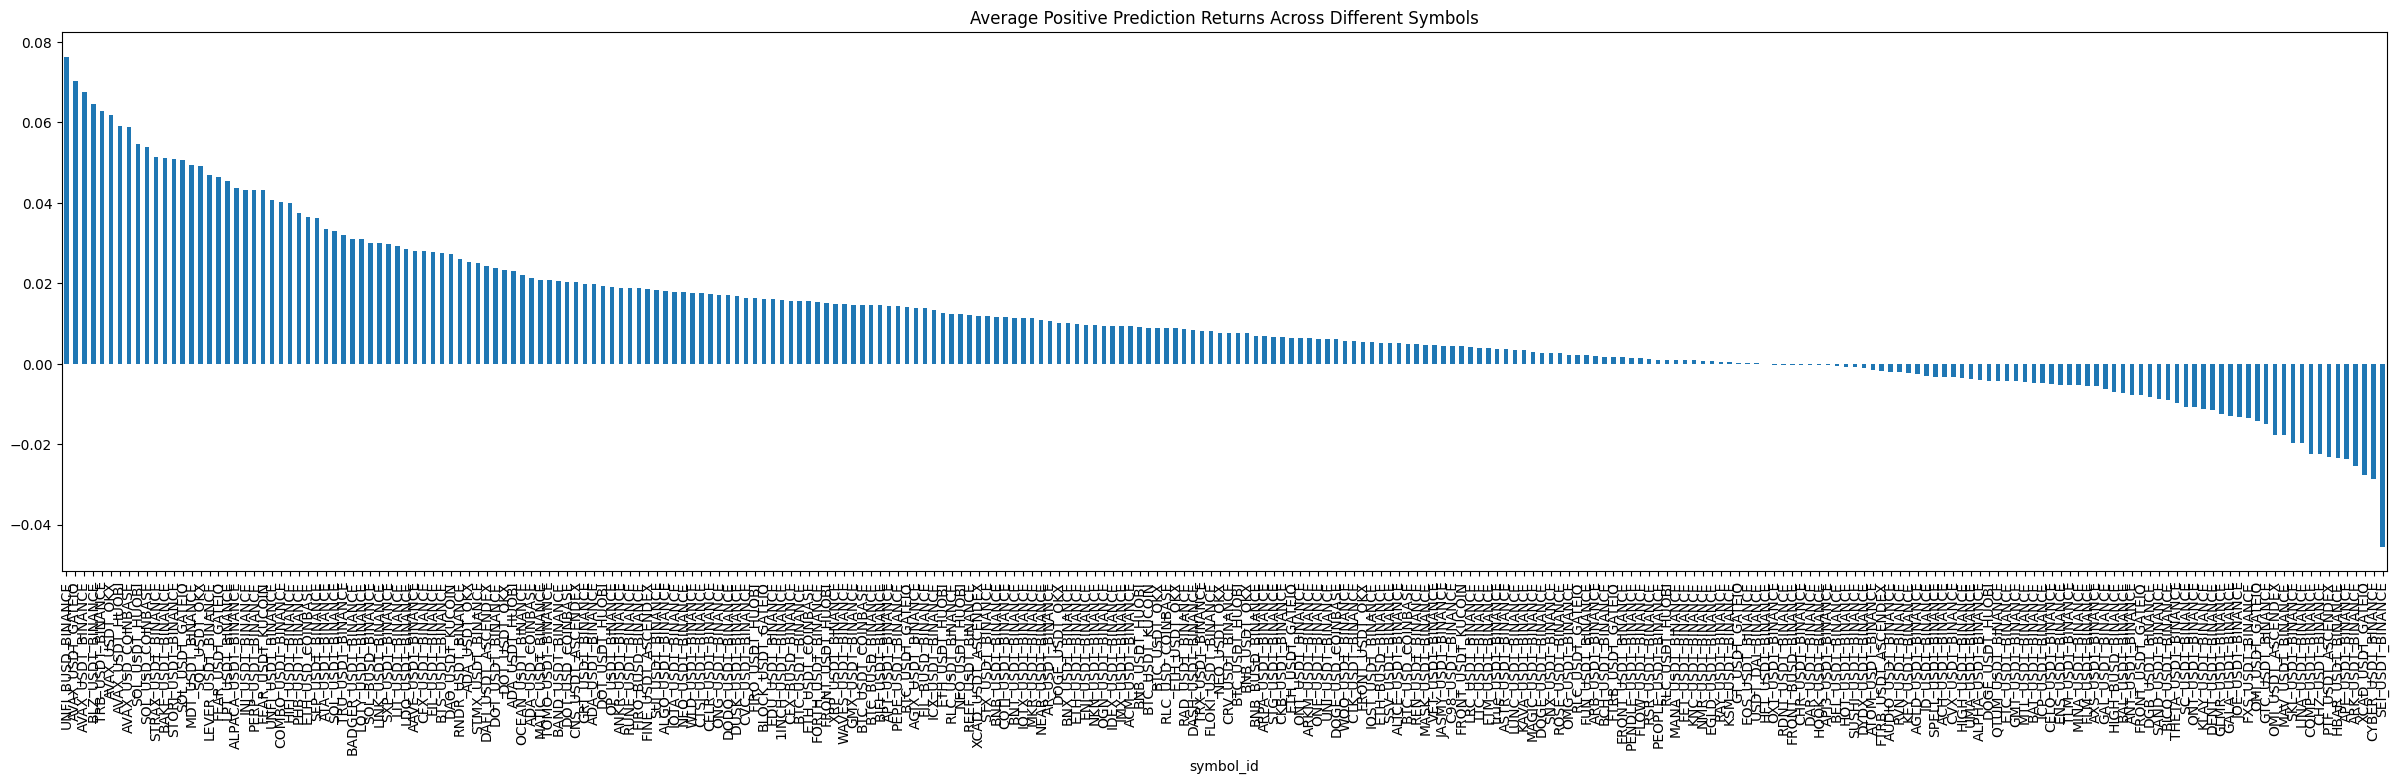

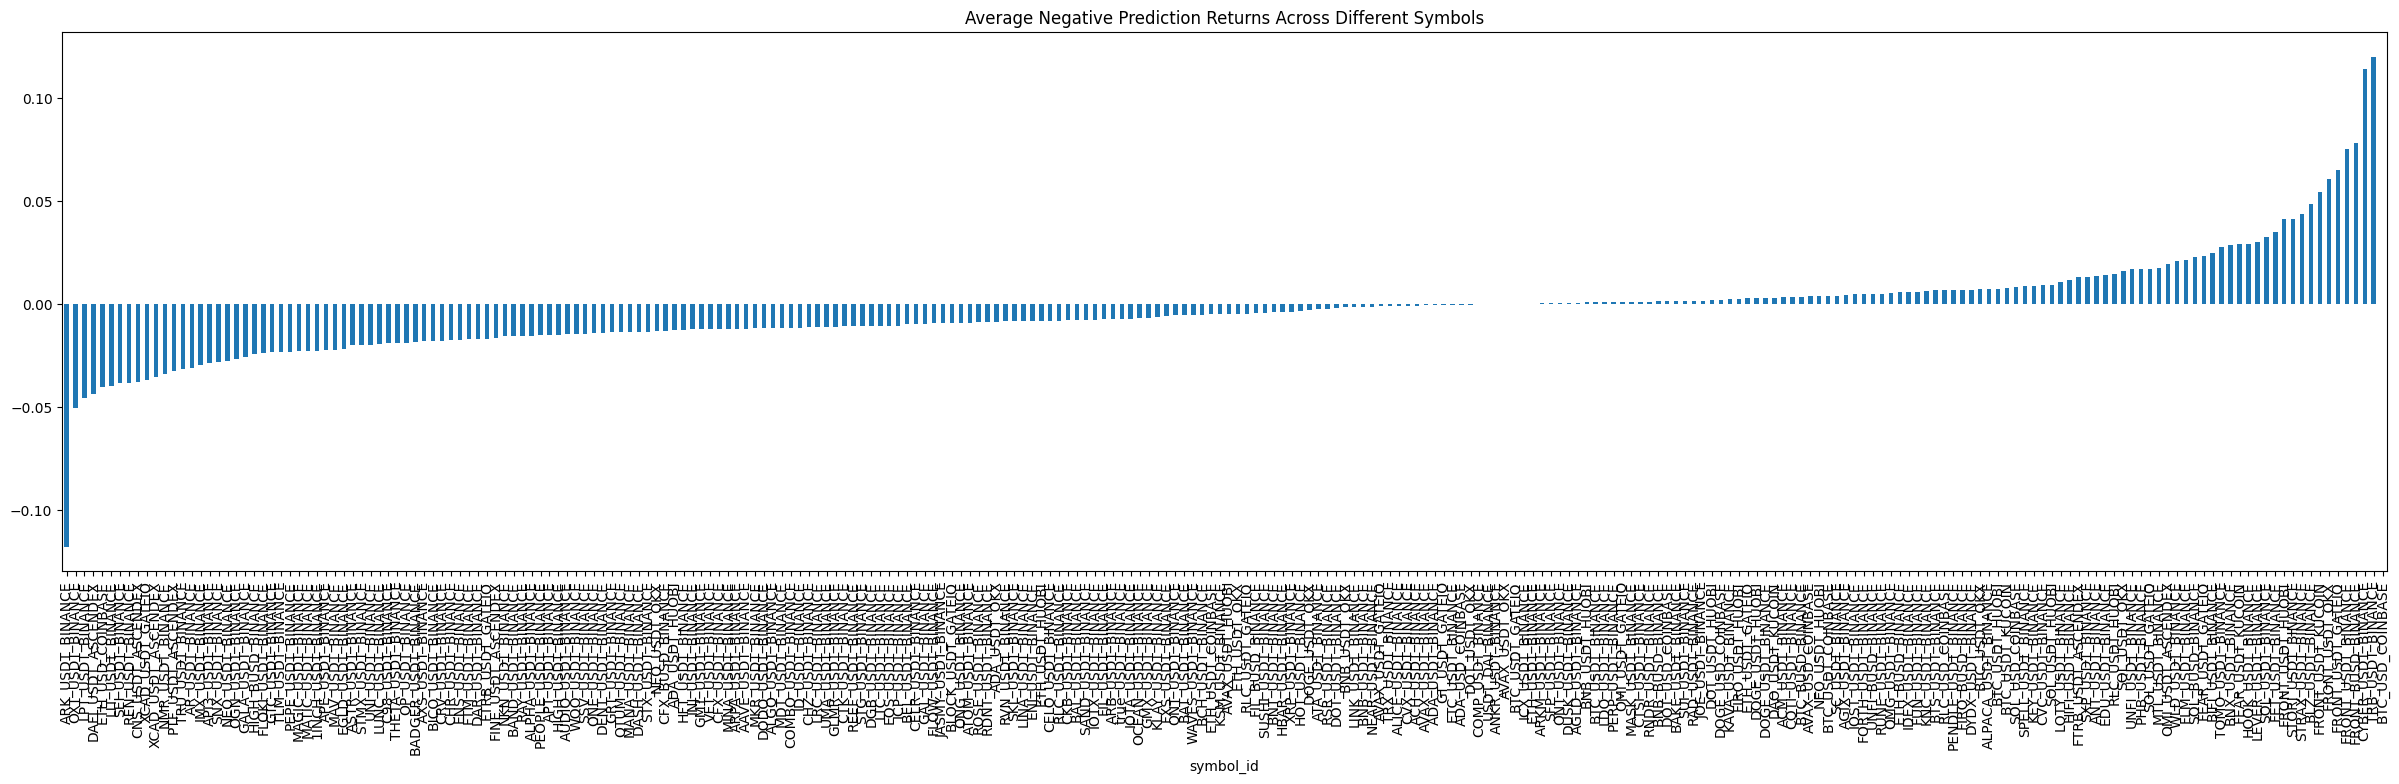

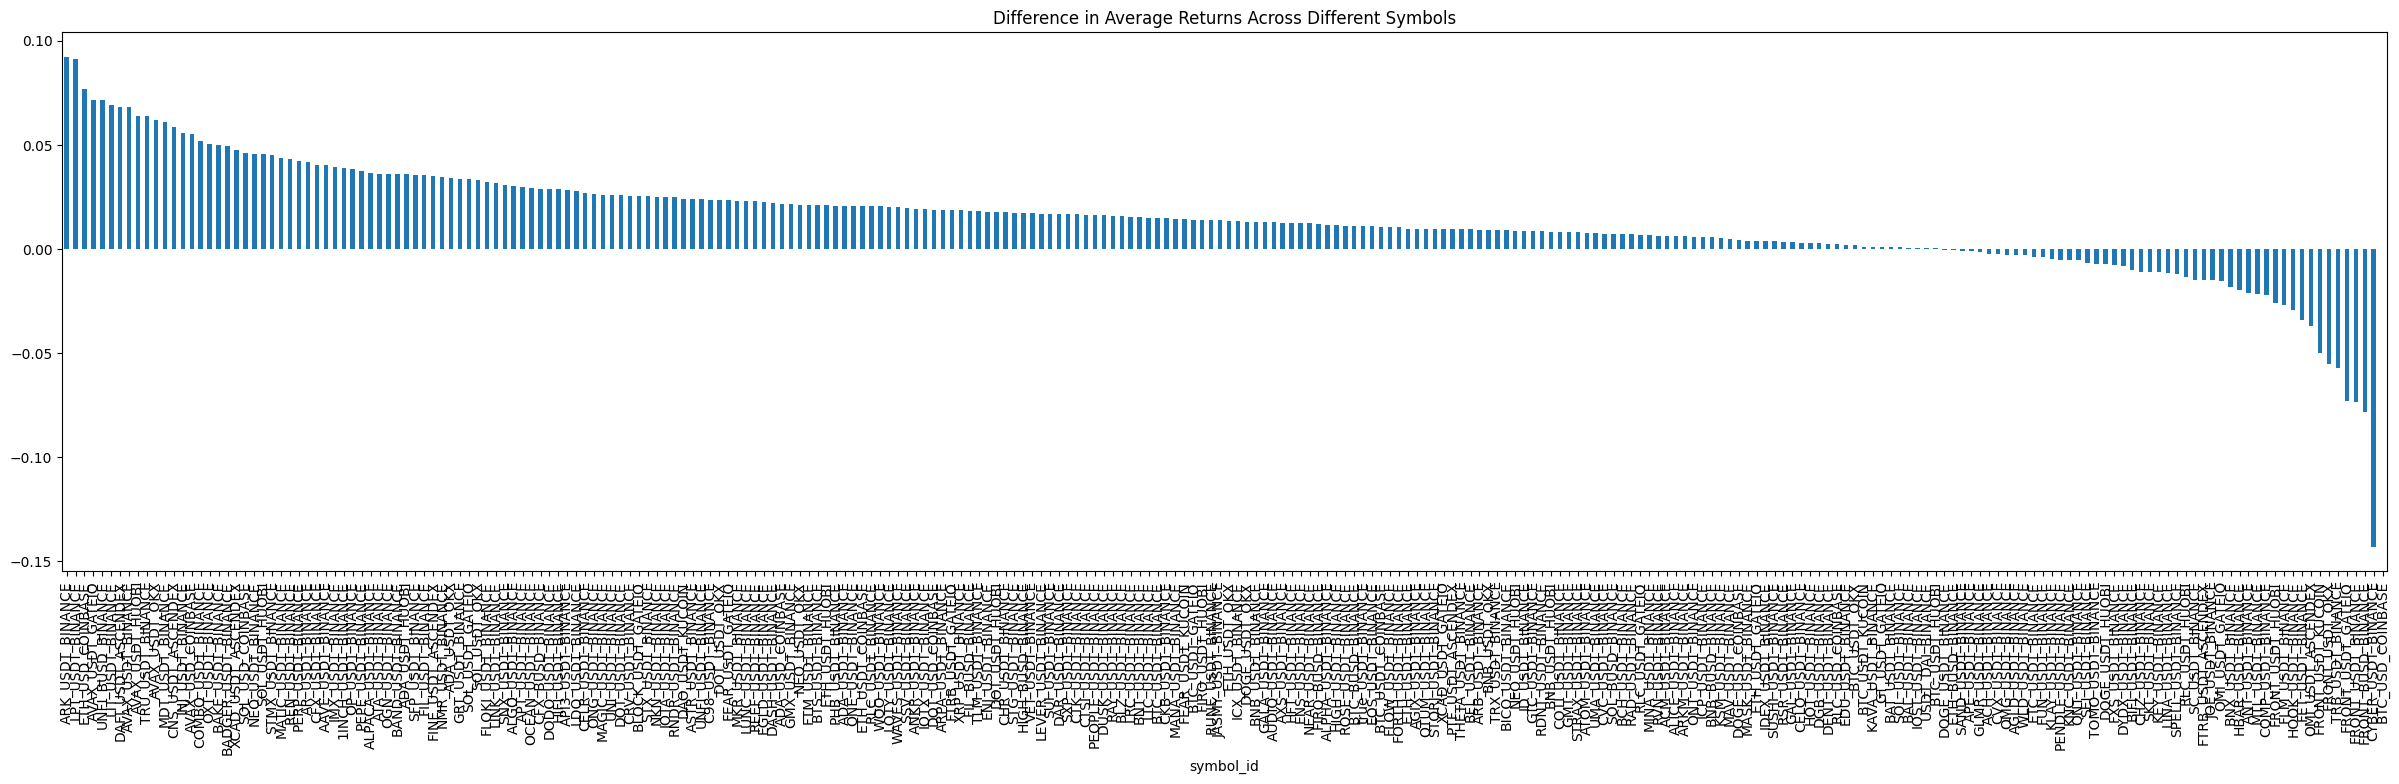

In [25]:
oos_avg_pred_returns = X_test.groupby(['symbol_id', 'y_pred'])['trade_returns_h7'].mean()
positive = oos_avg_pred_returns.loc[(slice(None), 1)]
# positive = positive.reindex(X_test['symbol_id'].unique(), fill_value = 0)

negative = oos_avg_pred_returns.loc[(slice(None), 0)]
# negative = negative.reindex(X_test['symbol_id'].unique(), fill_value = 0)

diff = (positive - negative)

# Bar plot of the average positive prediction returns across different symbols (Seaborn)
plt.figure(figsize = (30, 7))
positive = positive.sort_values(ascending = False)
positive.plot(kind = 'bar')
plt.title('Average Positive Prediction Returns Across Different Symbols')
plt.xticks(rotation = 90)
plt.show()

# Bar plot of the average negative prediction returns across different symbols (Seaborn)
plt.figure(figsize = (30, 7))
negative = negative.sort_values(ascending = True)
negative.plot(kind = 'bar')
plt.title('Average Negative Prediction Returns Across Different Symbols')
plt.xticks(rotation = 90)
plt.show()

# Bar plot of the difference in average returns across different symbols (Seaborn)
plt.figure(figsize = (30, 7))
diff = diff.sort_values(ascending = False)
diff.plot(kind = 'bar')
plt.title('Difference in Average Returns Across Different Symbols')
plt.xticks(rotation = 90)
plt.show()

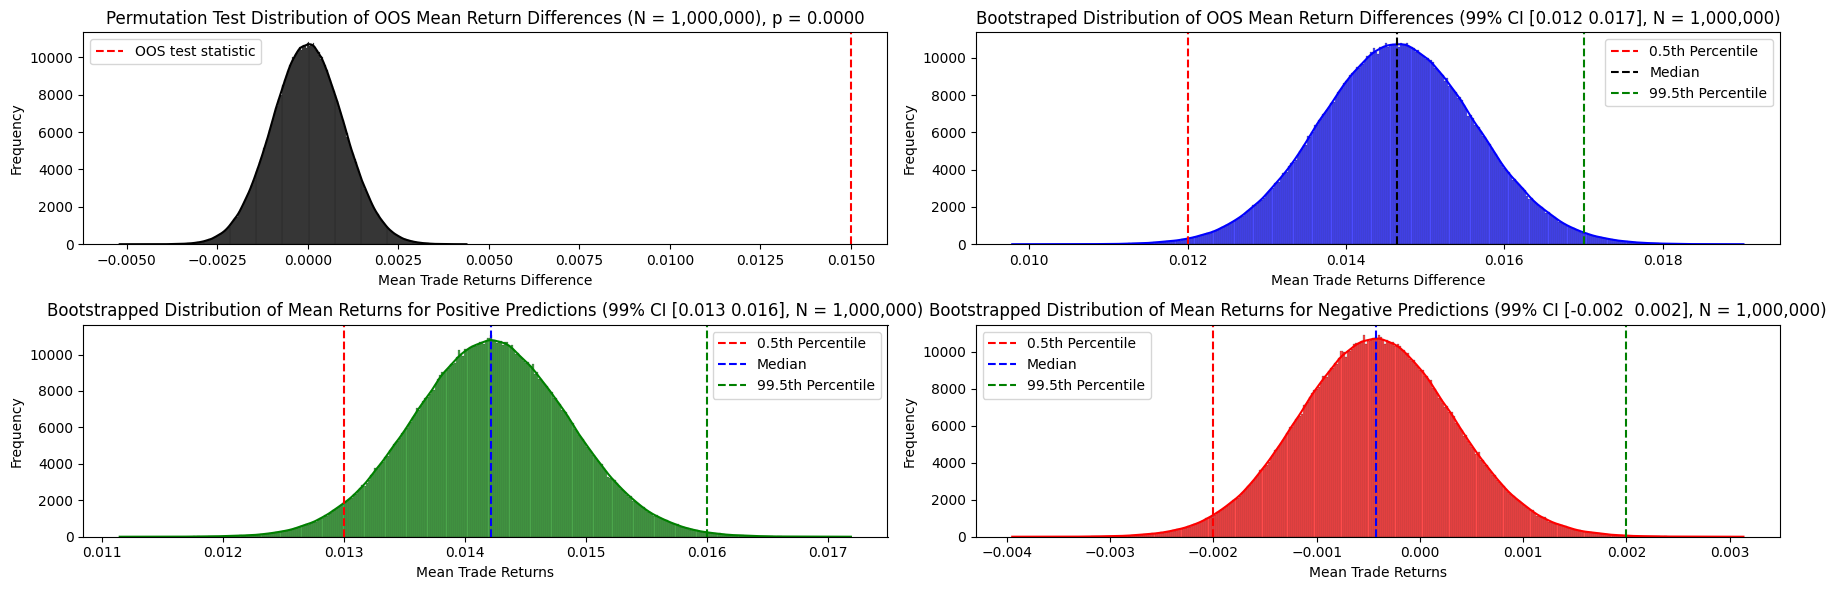

In [26]:
# Run the OOS statistical tests to check model robustness
run_oos_statistical_tests(
    y_pred_test, 
    X_test['trade_returns_h7'].values, 
    n_simulations = 1_000_000,
    sample_statistic = sample_statistic
)

In [30]:
# Drop the y_pred column
drop_cols = ['y_pred', 'y_pred_random', 'forward_returns_7','forward_returns_30', 'forward_returns_1', 'forward_avg_returns_1_7d', 'forward_pos_neg_volatility_ratio_7', 'forward_returns_7']
X_test.drop(columns = drop_cols, errors = 'ignore', inplace = True)